## Problem set 10

**Problem 0** (-2 points for every missing green OK sign. If you don't run the cell below, that's -14 points.)

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.


/Users/varon/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


You will work with the kaggle house price dataset in this problem set and work through a couple of different feature importance metrics. We provide code to train an XGBoost regression model to start you off. 

The main take-away from this problem set is that feature importance is not easy to measure and it depends strongly on what metric you use. 

In [2]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv('student-por.csv', sep = ';')
convert_dict = {'school': str,
                'sex': str,
                'address': str,

                'famsize': str,

                'Pstatus': str,

                'Mjob': str,

                'Fjob': str,
                'reason': str,

                'guardian': str,

                'schoolsup': str,

                'famsup': str,

                'activities': str,

                'nursery': str,

                'higher': str,

                'internet': str,

                'romantic': str,
                
                }
print(df.shape)
df = df.astype(convert_dict)
for col in df.columns:
    #print(df[col].unique())
    print(col)
    #print(df[col].dtype)


df = df.replace(r'^\s*$', np.nan, regex=True)

# the target variable
y = df['G3']
df.drop(columns=['G3'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(X.shape)
# the feature names
ftrs = df.columns

(649, 33)
school
sex
age
address
famsize
Pstatus
Medu
Fedu
Mjob
Fjob
reason
guardian
traveltime
studytime
failures
schoolsup
famsup
paid
activities
nursery
higher
internet
romantic
famrel
freetime
goout
Dalc
Walc
health
absences
G1
G2
G3
(649, 32)


In [6]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(389, 32)
(130, 32)
(130, 32)


In [7]:
# collect the various features
cat_ftrs= ['school','sex', 'address','famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian','schoolsup', 'famsup','paid','activities', 'nursery', 'higher', 'internet' , 'romantic']


num_ftrs = ['G1','G2','age', 'failures', 'studytime', 'traveltime', 'absences', 'Medu',  'Fedu', 'famrel', 'freetime', 'goout' ,'Dalc', 'Walc', 'health']

In [8]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# # ordinal encoder
# ordinal_transformer = Pipeline(steps=[
#     ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
#     ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

In [9]:
# fit_transform the training set
print(X_train.columns)
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)
ftr_names = df_test.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2'],
      dtype='object')
(389, 58)
(130, 58)
(130, 58)


In [10]:
# train the XGBoost model
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()
XGB.set_params(**ParameterGrid(param_grid)[0])
XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


the CV RMSE: 1.527669950715332
the test RMSE: 1.0745701614550331
the test R2: 0.8374554587947918


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


**Problem 1** (5 points)

Calculate the perturbation feature importance values on the test set and visualize the results. This dataset has many features so show only the top 10 most important ones on the figure. You can use the code from the lecture notes or work with sklearn's [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

In [11]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

#result = permutation_importance(XGB, df_test, y_test, n_repeats=10,random_state=0)

np.random.seed(42)

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = XGB.score(df_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == ' <=50K')/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        df_test_shuffled = df_test.copy()
        df_test_shuffled[ftr_names[i]] = np.random.permutation(df_test[ftr_names[i]].values)
        acc_scores.append(XGB.score(df_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

test score =  0.8374554587947918
test baseline =  0.0
shuffling num__G1
   shuffled test score: 0.814 +/- 0.013
shuffling num__G2
   shuffled test score: -0.543 +/- 0.142
shuffling num__age
   shuffled test score: 0.831 +/- 0.004
shuffling num__failures
   shuffled test score: 0.836 +/- 0.003
shuffling num__studytime
   shuffled test score: 0.837 +/- 0.003
shuffling num__traveltime
   shuffled test score: 0.836 +/- 0.001
shuffling num__absences
   shuffled test score: 0.807 +/- 0.029
shuffling num__Medu
   shuffled test score: 0.836 +/- 0.002
shuffling num__Fedu


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

   shuffled test score: 0.838 +/- 0.001
shuffling num__famrel
   shuffled test score: 0.837 +/- 0.001
shuffling num__freetime
   shuffled test score: 0.836 +/- 0.003
shuffling num__goout
   shuffled test score: 0.835 +/- 0.002
shuffling num__Dalc
   shuffled test score: 0.838 +/- 0.003
shuffling num__Walc
   shuffled test score: 0.838 +/- 0.001
shuffling num__health
   shuffled test score: 0.831 +/- 0.003
shuffling cat__school_GP
   shuffled test score: 0.84 +/- 0.002
shuffling cat__school_MS
   shuffled test score: 0.838 +/- 0.0
shuffling cat__sex_F


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

   shuffled test score: 0.837 +/- 0.001
shuffling cat__sex_M
   shuffled test score: 0.837 +/- 0.0
shuffling cat__address_R
   shuffled test score: 0.837 +/- 0.0
shuffling cat__address_U
   shuffled test score: 0.838 +/- 0.0
shuffling cat__famsize_GT3
   shuffled test score: 0.838 +/- 0.001
shuffling cat__famsize_LE3
   shuffled test score: 0.837 +/- 0.001
shuffling cat__Pstatus_A
   shuffled test score: 0.838 +/- 0.001
shuffling cat__Pstatus_T
   shuffled test score: 0.837 +/- 0.0
shuffling cat__Mjob_at_home
   shuffled test score: 0.837 +/- 0.0
shuffling cat__Mjob_health
   shuffled test score: 0.838 +/- 0.0
shuffling cat__Mjob_other


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

   shuffled test score: 0.842 +/- 0.003
shuffling cat__Mjob_services
   shuffled test score: 0.838 +/- 0.0
shuffling cat__Mjob_teacher
   shuffled test score: 0.835 +/- 0.002
shuffling cat__Fjob_at_home
   shuffled test score: 0.837 +/- 0.0
shuffling cat__Fjob_health
   shuffled test score: 0.837 +/- 0.001
shuffling cat__Fjob_other
   shuffled test score: 0.837 +/- 0.0
shuffling cat__Fjob_services
   shuffled test score: 0.842 +/- 0.003
shuffling cat__Fjob_teacher
   shuffled test score: 0.837 +/- 0.0
shuffling cat__reason_course
   shuffled test score: 0.837 +/- 0.0
shuffling cat__reason_home
   shuffled test score: 0.838 +/- 0.001
shuffling cat__reason_other


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

   shuffled test score: 0.837 +/- 0.004
shuffling cat__reason_reputation
   shuffled test score: 0.837 +/- 0.0
shuffling cat__guardian_father
   shuffled test score: 0.837 +/- 0.001
shuffling cat__guardian_mother
   shuffled test score: 0.838 +/- 0.0
shuffling cat__guardian_other
   shuffled test score: 0.837 +/- 0.0
shuffling cat__schoolsup_no
   shuffled test score: 0.836 +/- 0.001
shuffling cat__schoolsup_yes
   shuffled test score: 0.837 +/- 0.0
shuffling cat__famsup_no
   shuffled test score: 0.843 +/- 0.007
shuffling cat__famsup_yes
   shuffled test score: 0.838 +/- 0.001
shuffling cat__paid_no
   shuffled test score: 0.837 +/- 0.0
shuffling cat__paid_yes


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

   shuffled test score: 0.837 +/- 0.0
shuffling cat__activities_no
   shuffled test score: 0.837 +/- 0.001
shuffling cat__activities_yes
   shuffled test score: 0.838 +/- 0.0
shuffling cat__nursery_no
   shuffled test score: 0.837 +/- 0.001
shuffling cat__nursery_yes
   shuffled test score: 0.838 +/- 0.0
shuffling cat__higher_no
   shuffled test score: 0.838 +/- 0.0
shuffling cat__higher_yes
   shuffled test score: 0.838 +/- 0.0
shuffling cat__internet_no
   shuffled test score: 0.837 +/- 0.001
shuffling cat__internet_yes
   shuffled test score: 0.837 +/- 0.0
shuffling cat__romantic_no
   shuffled test score: 0.837 +/- 0.001
shuffling cat__romantic_yes
   shuffled test score: 0.837 +/- 0.0


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

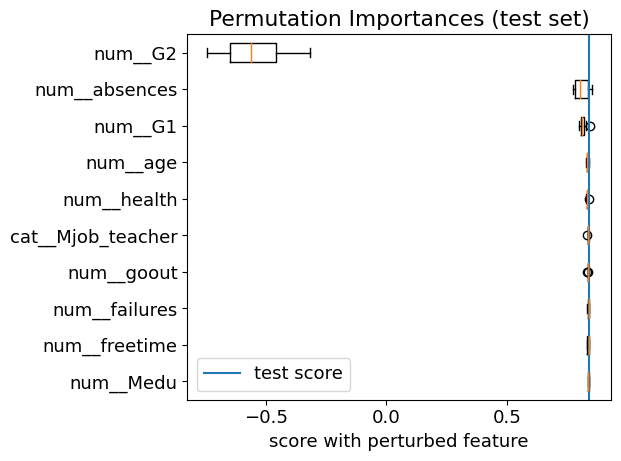

In [12]:

sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(scores[sorted_indcs][-10:].T,labels=ftr_names[sorted_indcs][-10:],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

**Problem 2** (10 points)

As we discussed in class, XGBoost implements 5 different metrics to measure feature importance. Calculate all 5 metrics and create 5 figures showing the top 10 most important features for each metric.

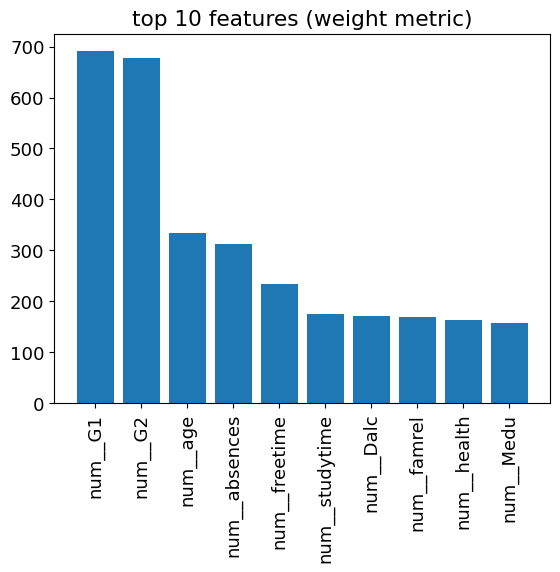

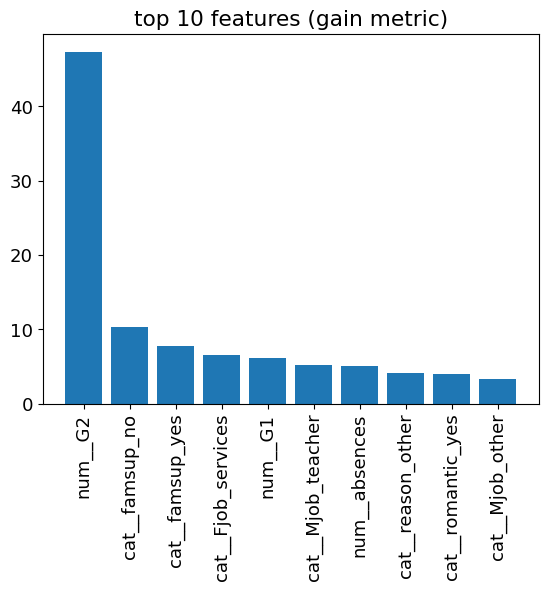

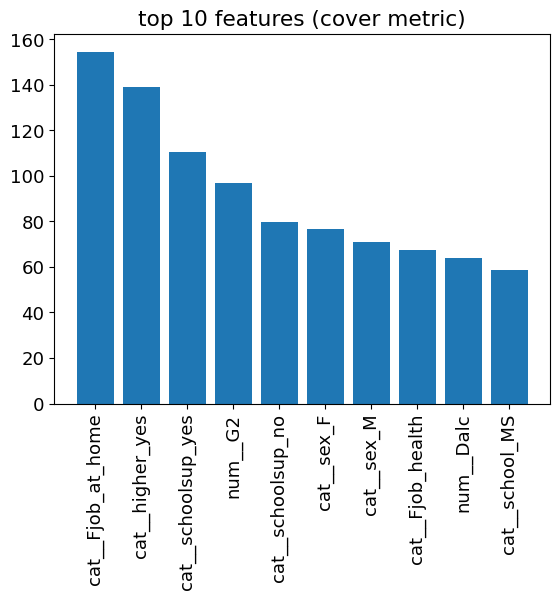

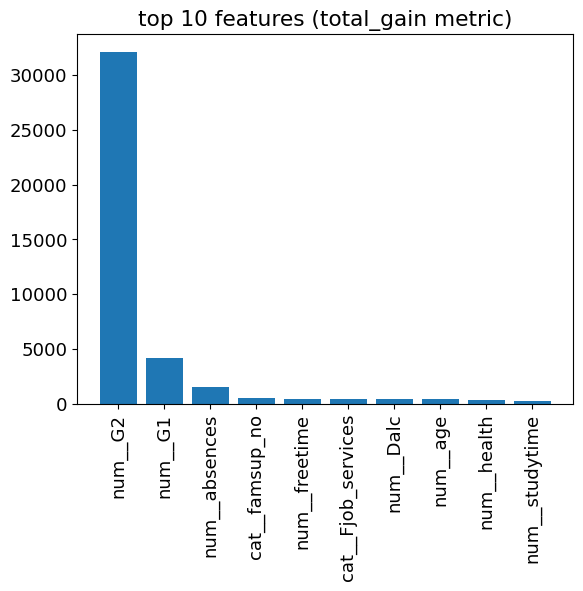

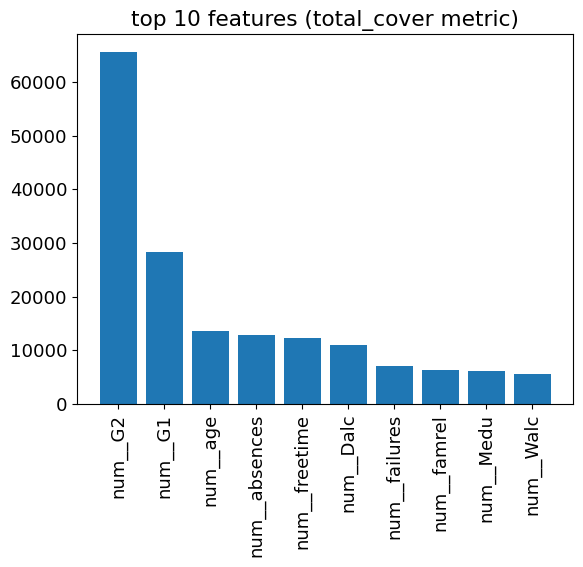

In [13]:
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
from operator import itemgetter
N = 10
for importance in importance_types:
    dic = XGB.get_booster().get_score(importance_type= importance)
    data = dict(sorted(dic.items(), key = itemgetter(1), reverse = True)[:N])
    names = list(data.keys())
    values = list(data.values())
    plt.title('top 10 features (' + importance + ' metric)')
    plt.bar(range(len(data)), values, tick_label=names)
    plt.xticks(rotation ='vertical')
    plt.show()


In [14]:
XGB.feature_importances_

array([0.03824   , 0.29733324, 0.00739371, 0.00904202, 0.00919959,
       0.00790256, 0.03151362, 0.00804469, 0.00775912, 0.00651728,
       0.01279507, 0.00705965, 0.01470223, 0.00543529, 0.01180586,
       0.01414483, 0.01495097, 0.0092122 , 0.00683607, 0.00614212,
       0.00499978, 0.00522433, 0.02053078, 0.00485687, 0.00524551,
       0.00581137, 0.00361585, 0.02091622, 0.00574311, 0.03281448,
       0.00475571, 0.00441213, 0.00608153, 0.04102697, 0.0028597 ,
       0.00659872, 0.01345649, 0.02556697, 0.00573379, 0.01239468,
       0.00541562, 0.0044613 , 0.00748051, 0.00663354, 0.064688  ,
       0.04870753, 0.00336421, 0.00091755, 0.00496778, 0.01194739,
       0.01524732, 0.00576617, 0.00719114, 0.01019923, 0.00468905,
       0.00911008, 0.00517562, 0.02536286], dtype=float32)

**Problem 3a** (10 points)

Let's now calculate the shap values of the test set points. Use the shap values to calculate global feature importance values and prepare a plot that shows the top 10 most important features. Choose one of the two approaches:

1) You can use the shap package as we did in class. You will encounter an error which you'll need to solve yourself. Please do not ask about this error on Ed Discussion. Instead, figure it out yourself. You'll also need to manually change some parameters of the plot.

2) XGBoost can directly calculate shap values for you (look up how) but you need to recreate the figures with matplotlib because XGBoost's shap values don't come with visualizations. 

Both approaches take roughly the same amount of time to work through. 

In [15]:

import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
booster = XGB.get_booster()
explainer = shap.TreeExplainer(booster)

# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(df_train[:1000])
print(np.shape(shap_values))

(389, 58)


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


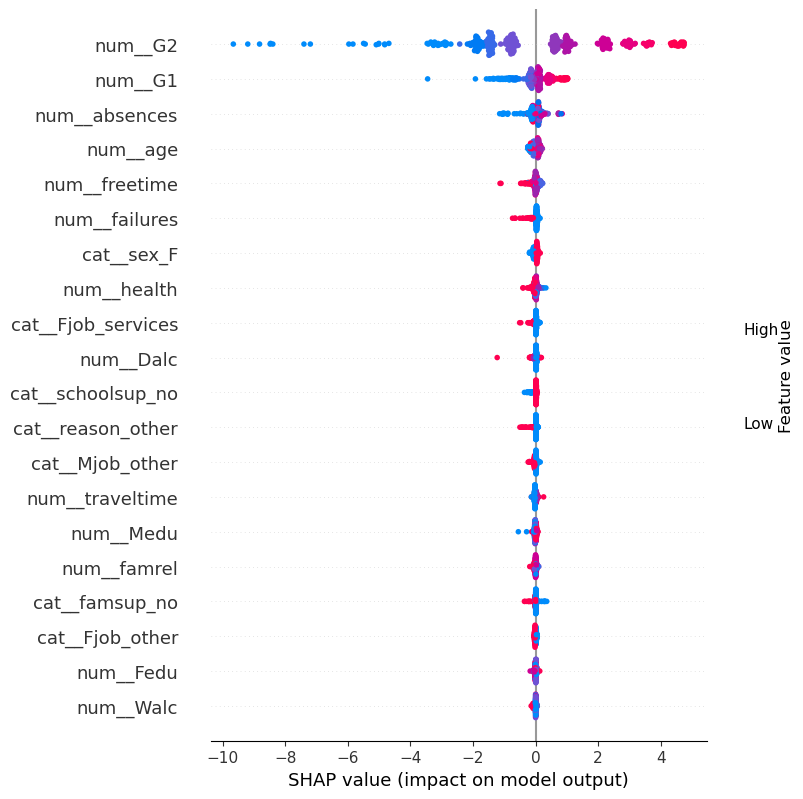

In [16]:
shap.summary_plot(shap_values, df_train[:1000],feature_names = feature_names)
# index = 42 # the index of the point to explain
# print(explainer.expected_value[0]) # we explain class 0 predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = X_test_transformed[index,:],feature_names = feature_names)

**Problem 3b** (10 points)

Let's take a look at some specific data points with indices 0, 100, and 200. For each data point, create a force plot and describe in a paragraph or two which features contribute positively and negatively to the prediction.

For the point with index 200, our house with the highest price of the three considered, the basement quality feature pushed the house value up. The overall quality feature also pushed this house (index 200) value up, while overall quality lowered the price of the sample with index 100.


In [17]:
index = 0 # the index of the point to explain
print(explainer.expected_value) # we explain class 0 predictions
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:],feature_names = feature_names)

11.991264


In [18]:
index = 100 # the index of the point to explain
print(explainer.expected_value) # we explain class 0 predictions
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:],feature_names = feature_names)

11.991264


In [19]:
index = 42 # the index of the point to explain
print(explainer.expected_value) # we explain class 0 predictions
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:],feature_names = feature_names)

11.991264


**Problem 4** (5 points)

You calculated 7 different global feature importance metrics (perturbation, 5 XGB metrics, global shap). Unfortunately the ranked features can be quite different depending on the importance metric used. Write a short discussion on the similarities and differences amongst the 7 methods. Are there features that tend to be in the top 3-5 regardless of the approach used? Discuss the pros and cons of the various approaches!


There are indeed features that show-up as top-3/ top-5 across different metrics. For instance, lot area is the second most important feature under the weight metric, and the third most important feature under the total cover metric.  Similarly overall quality is the most important feature according to the global shap values, and it is also the most important feature according to the total_gain metric.

Some importance metrics use the same underlying approach to compute. 
For instance, the gini impurity is used to calculate both the "gain" metric from XGboost, as well as sklearn's .feature_importances  model attribute. 

Other metrics are more unique- such as the SHAP global values which use the shap values from game theory.

The different importance metrics provide different points of view, as features might be important to the algorithm in different ways. It is thus important to consider various vantage points and understand the different metrics.
